## 1. Settings

In [1]:
!ls
!unzip dog.zip

dog.zip  sample_data  utils.py
Archive:  dog.zip
   creating: dog/test/
   creating: dog/test/bordercollie/
  inflating: dog/test/bordercollie/10455174_3b9b00.jpg  
  inflating: dog/test/bordercollie/30b06965273874a8d22ade31db5b5ca1.jpg  
  inflating: dog/test/bordercollie/3e131e891e0b6ef834bfa2462f631142.jpg  
  inflating: dog/test/bordercollie/5c2f2a7d29b172149830b07e1e9ebf5a.jpg  
  inflating: dog/test/bordercollie/Border_Collie_dog.jpg  
  inflating: dog/test/bordercollie/border-collie.jpeg  
 extracting: dog/test/bordercollie/bordercollie_400x378.jpg  
  inflating: dog/test/bordercollie/border-collie-1.jpg  
  inflating: dog/test/bordercollie/border-collie-4.jpg  
  inflating: dog/test/bordercollie/Border-Collie-Dog.jpg  
  inflating: dog/test/bordercollie/Border-Collie-laying-down.jpg  
  inflating: dog/test/bordercollie/Border-Collie-On-White-01.jpg  
  inflating: dog/test/bordercollie/Border-Collie-origin.jpg  
  inflating: dog/test/bordercollie/Border-Collie-Shedding-900x500.j

In [2]:
import torch 
print(torch.__version__)

print(torch.cuda.device(0))
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1.8.1+cu101
1
Tesla T4
True


### 1) Important required libraries

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

### 2) Hyperparameter

In [4]:
batch_size = 16
learning_rate = 0.0001
epoch = 20

n_node = 1024 # customized last layer의 노드 수
dropratio = 0.5 # 얼마나 drop 시킬지 inverse keepratio

imgsize = 256 # 입력이미지

## 2. Data Loader
### 트레이닝 데이터

In [5]:
img_dir = "dog/train"  #!!!!!!!!!!!!!!!!!!!!dog/train하면됨
train_data = dset.ImageFolder(img_dir, transforms.Compose([
                transforms.CenterCrop(imgsize*2), # 1. CenterCrop(512)
                transforms.RandomCrop(imgsize), # 2. RandomCrop
                transforms.RandomHorizontalFlip(), # 3. RandomHorizonatalFlip

                transforms.Resize(imgsize),
                transforms.ToTensor()
                ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size, # batch_size만큼 묶어서
                                          shuffle=True, num_workers=2)

46


### 고정된 데이터 셋

In [7]:
# 2. Dev data
img_dir = "dog/val"  #!!!!!!!!!!!!!!!!!!!!dog/train하면됨
dev_data = dset.ImageFolder(img_dir, transforms.Compose([
                transforms.CenterCrop(size=imgsize), 
                transforms.RandomCrop(imgsize),
                transforms.ToTensor()
                ]))

dev_batch = data.DataLoader(dev_data, batch_size=batch_size, # batch_size만큼 묶어서
                                          shuffle=True, num_workers=2)

In [8]:
# 3. Test data
img_dir = "dog/test"  #!!!!!!!!!!!!!!!!!!!!dog/train하면됨
test_data = dset.ImageFolder(img_dir, transforms.Compose([
                transforms.CenterCrop(size=imgsize), 
                transforms.RandomCrop(imgsize),
                transforms.ToTensor()
                ]))

test_batch = data.DataLoader(test_data, batch_size=batch_size, # batch_size만큼 묶어서
                                          shuffle=True, num_workers=2)

nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d"
         %(train_data.__len__(), dev_data.__len__(), test_data.__len__()))

# of classes: 2
['bordercollie', 'retriever']
{'bordercollie': 0, 'retriever': 1}
46
Training: 46, Dev: 19, Test: 32


In [18]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['bordercollie', 'retriever']
['bordercollie', 'retriever']
['bordercollie', 'retriever']


## 3. Model
### 1) Pretrained VGG Model

In [9]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0]) # sequential convolution layer
print(list(vgg.children())[-1]) # fully connected layer

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth



features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU

In [10]:
print(list(vgg.children())[0][0]) # sequential convolution layer의 0번째 가져옴
# print(list(vgg.children())[0][:9]) # sequential convolution layer의 0-8번째 가져옴

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### 2) Customized Fully Model

In [11]:
base_dim = 64
fsize = int(imgsize/32)

class MyVGG(nn.Module):
    def __init__(self):
        super(MyVGG, self).__init__()
        # sequential convolution layer 다 가져옴  
        self.layer0=nn.Sequential(*list(vgg.children())[0])
        # fully connected layer는 내꺼로 대체함
        self.layer1=nn.Sequential(
            nn.Linear(8*base_dim*fsize*fsize, n_node), #!!!!!!!!!
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), #0.3만큼 drop하자

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),

            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio), #0.3만큼 drop하자

            nn.Linear(n_node, nclass) ##nclass!!!!
        )
        # weight initialization
        for m in self.layer1.modules():
            #print(m)
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal_(m.weight.data) #ReLU 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal_(m.weight.data) #ReLU 일 때
                m.bias.data.fill_(0)
    def forward(self, x):
        out=self.layer0(x)
        out=out.view(out.size(0), -1)
        out=self.layer1(out)
        return out

### 3) Model on GPU

In [12]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False

for params in model.layer1.parameters():
    params.required_grad = True

In [13]:
for name in model.children():
    print(name)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer & Loss

In [14]:
# loss function, optimizer 선언
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.layer1.parameters(), lr = learning_rate)

## 5. Train

In [19]:
import utils

total_time = 0
disp_step = 10

to_train = True
if(to_train==False):
    netname = './nets/BorderRetriever_vgg19_10.pkl'
    model = torch.load(netname)
else:
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" %(test_corr, dev_corr, test_corr))
    model.train()
    
    netname = './nets/BorderRetriever_vgg19_10.pkl'
    
    #graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
    #학습 재시작 않는다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.."%i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()
            
            optimizer.zero_grad()
            ouput = model(img)
            loss = loss_func(ouput, label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if(i % disp_step == 0) or (i==epoch-1):
            torch.save(model, netname+'_%d.pkl'%i,)
            print("\n[%d/%d] loss: %.3f, " %(i,epoch, (loss.cpu()).data.numpy())),

            #train, dev, test accr
            model.eval()
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f"%(test_corr, dev_corr, test_corr))
            model.train()
            print("time: %.2f sec.." %(total_time))

            # graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)  


3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 87.50, dev: 94.74, test: 87.50
0..

[0/20] loss: 0.418, 
Correct of train: 84.38, dev: 94.74, test: 84.38
time: 1.15 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/20] loss: 0.071, 
Correct of train: 87.50, dev: 89.47, test: 87.50
time: 11.84 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..

[19/20] loss: 0.107, 
Correct of train: 90.62, dev: 94.74, test: 90.62
time: 21.59 sec..
Total time: 21.59 sec


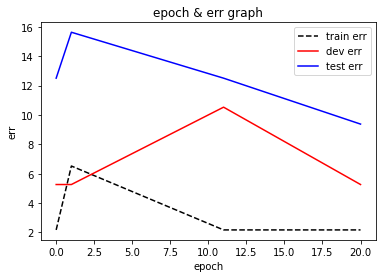

In [22]:
# epoch-err curve
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err',linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')

    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6.Evaluation for dev & test data

Normalized confusion matrix


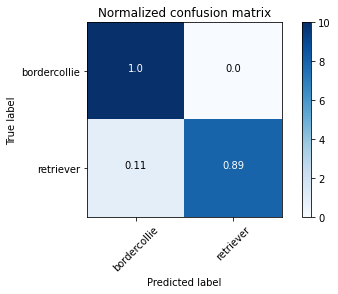

Confusion matrix, without normalization


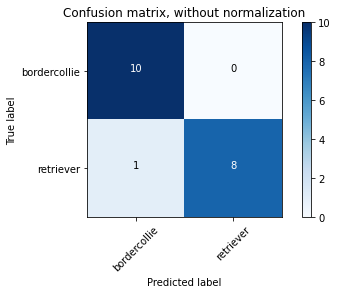

	 acc  |	 pre  |	 rec  |	 f1
 bordercollie: 0.95 |	 0.91 |	 1.00 |	 0.95
 retriever: 0.95 |	 1.00 |	 0.89 |	 0.94
*accuracy: 0.95, precision: 0.95, recall: 0.94, *f1 score: 0.95
[AP]
bordercollie: 1.00
retriever: 1.00

[mAP] 1.000
[miAP] 0.974


(array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0]),
 array([0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1]),
 array([0.9694472 , 0.99993199, 0.99614275, 0.99925452, 0.99850661,
        0.92336178, 0.99341363, 0.99752283, 0.98703903, 0.83498633,
        0.84485126, 0.99991524, 0.99963033, 0.98638225, 0.64191413,
        0.942123  , 0.9991169 , 0.99102551, 0.85197467]))

In [23]:
model.eval()
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


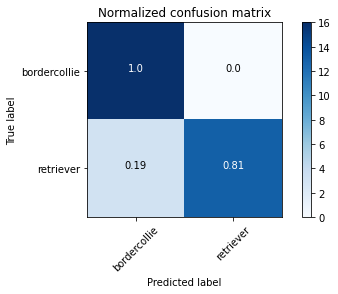

Confusion matrix, without normalization


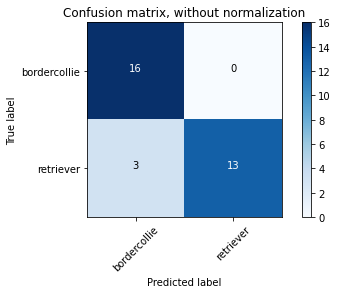

	 acc  |	 pre  |	 rec  |	 f1
 bordercollie: 0.91 |	 0.84 |	 1.00 |	 0.91
 retriever: 0.91 |	 1.00 |	 0.81 |	 0.90
*accuracy: 0.91, precision: 0.92, recall: 0.91, *f1 score: 0.91
[AP]
bordercollie: 0.98
retriever: 0.99

[mAP] 0.982
[miAP] 0.953


In [24]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: bordercollie
 True predicted images/total bordercollie category: 10 / 10
Predicted probability:
[9.9991524e-01 8.4739309e-05]


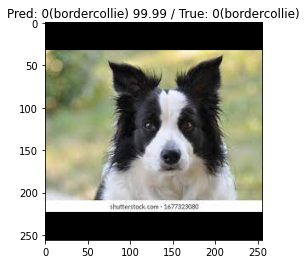

Predicted probability:
[0.99102557 0.00897441]


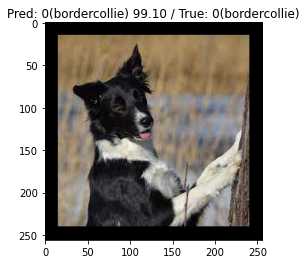

 False predicted images/total bordercollie category: 0 / 10
Category: retriever
 True predicted images/total retriever category: 8 / 9
Predicted probability:
[0.01296094 0.987039  ]


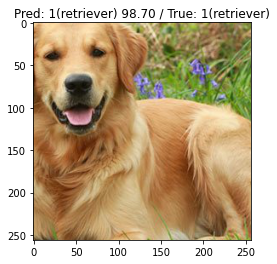

Predicted probability:
[0.0766382 0.9233618]


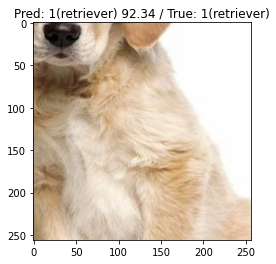

 False predicted images/total retriever category: 1 / 9
Predicted probability:
[0.85197467 0.1480253 ]


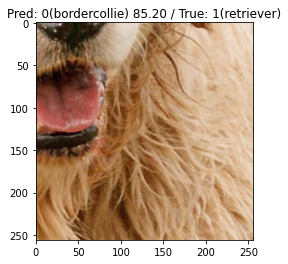

In [25]:
utils.VisTFPred(dev_batch, model, test_data.classes, batch_size, i_n=2)